In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier
#from lightgbm import LGBMRegressor

import numpy as np
import pandas as pd
import os
import pickle
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import json
from sklearn.feature_selection import RFE

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Lectura de vista minable

In [2]:
# dataset_ff_cf_lb_am_T.csv
dataset = pd.read_csv("dataset_ff_cf_lb_am_T.csv")
dataset.head(5)

,user_id,qty_adopciones_1M,qty_adopciones_3M,qty_adopciones_6M,qty_adopciones_9M,mes,anio,qty_dias_ultima_adopcion,qty_dias_ultimo_page_ingreso,snapshot_mes_x,...,ratio_adoption_preferencia_CONNECTION_SPEED_2.0,ratio_adoption_preferencia_CONNECTION_SPEED_3.0,ratio_adoption_interes_CONNECTION_SPEED,snapshot_mes,ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_1,ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_1.0,ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_63.0,ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_89.0,ratio_adoption_interes_ON_SITE_SEARCH_TERM,target
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,...,-999.0,0.0,0.0,9,0.0,-999.0,-999.0,-999.0,0.0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,...,0.0,-999.0,0.0,9,0.0,-999.0,-999.0,-999.0,0.0,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,9,...,0.0,0.0,0.0,9,0.0,-999.0,-999.0,-999.0,0.0,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,9,...,-999.0,-999.0,0.0,9,0.0,-999.0,-999.0,-999.0,0.0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,9,...,0.0,0.0,0.0,9,0.0,-999.0,-999.0,-999.0,0.0,0


In [3]:
dataset = dataset.drop(['FEC_EVENT_MAX','FEC_EVENT_MENOS_7D'], axis = 1)

In [4]:
dataset = dataset.replace(np.inf, 999)
dataset = dataset.fillna(999)

In [5]:
train_features = dataset.drop(['target'], axis = 1)
train_labels = dataset.target

In [60]:
len(dataset['user_id'])

11530

# Training

In [6]:
def crossValidationSelector(X, y, folds):  
    skf = StratifiedKFold(n_splits=folds)
    return skf.split(X, y)

In [7]:
def trainWithCrossValidation(kfold, base, learner):    
    # kfolds are the folds that return crossValidationSelector
    # base is the dataset
    # learner is the model with the best parameters
    proba = pd.DataFrame()
    preds = pd.DataFrame()
    X, y = base.drop(base.columns[-1], axis=1), base.iloc[:,-1] 
    
    for train_index, test_index in kfold:
#    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.loc.__getitem__(train_index), X.loc.__getitem__(test_index)
        y_train, y_test = y.loc.__getitem__(train_index), y.loc.__getitem__(test_index)    
        auxTest = X_test.copy()
        X_train = X_train.values.astype(np.float32, order="C")
        X_test = X_test.values.astype(np.float32, order="C")
        scaler = StandardScaler()
        scaler.fit(np.r_[X_train, X_test])
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    
        probabilidades, predicciones = train(learner, X_train, y_train, X_test, y_test)     
        auxTest['prob'] = probabilidades
        proba = pd.concat([proba, auxTest[['prob']]])
        
        auxTest['pred'] = predicciones
        preds = pd.concat([preds, auxTest[['pred']]])
        
    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = X.columns
    #fold_importance_df["importance"] = learner.feature_importance()
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    return proba, preds, learner

#####################################################################################################################


def train(learner, X_train, y_train, X_test, y_test, esr=20):
    mask = y_test.isin(y_train.unique()).values
    learner.fit(X_train, y_train,
                eval_set=[(X_test, y_test),
                          (X_test[mask], y_test[mask])
                          ],
                early_stopping_rounds=esr,
                verbose=True)
    #n_estimators = learner.best_iteration
    n_estimators = 10000
    probs = learner.predict_proba(X_test, ntree_limit=n_estimators)[:, -1]
    pred = learner.predict(X_test, ntree_limit=n_estimators)
    
    
    
    return probs, pred

# Metrics

In [8]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    return accuracy, predictions

# Tunning

<h6>Random search de los mejores parametros</h6>

In [9]:
# Se le pasa el modelo, un grid de parametros, los features y labels para entrenar
def trainRandomGrid(candidate, random_grid, train_features, train_labels):
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    model = candidate
    # Random search of parameters, using 3 fold cross validations
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    
    rf_random.fit(X = train_features, y= train_labels)
    
    # We can view the best parameters from fitting the random search
    # rf_random.best_params_

    return rf_random

<h6>Grid search a partir de Random search en busqueda de los mejores parametros</h6>

In [10]:
def trainGrid(candidate, param_grid, train_features, train_labels):
    # Create a based model
    model = candidate
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

    ######## TRAIN GRID SELECTOR #######
    # Fit the grid search to the data
    grid_search.fit(train_features, train_labels)
    #grid_search.best_params_
    return grid_search

# Ejecucion

<h6>Buscamos los mejores parametros de manera random para achicar el espacio de busqueda</h6>

In [11]:

model = LGBMClassifier()

params = {
    'learning_rate': [0.005],
    'num_leaves': [10],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5],
    'random_state' : [42], 
    'colsample_bytree' : [0.5],
    'subsample' : [0.5],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }


randomGrid = trainRandomGrid(model, params, train_features, train_labels)
best_random = randomGrid.best_estimator_

C:\Users\HP\Anaconda3\envs\galicia\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.6min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished


In [12]:
#Print best paramas and accuracy
best_random = randomGrid.best_estimator_
random_accuracy, preds = evaluate(best_random, train_features, train_labels)

print(randomGrid.best_estimator_)
print(random_accuracy)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.005, max_depth=5,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.01, n_estimators=100,
               n_jobs=-1, num_leaves=10, objective='binary', random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=0)
0.9662589990458843


In [13]:
pred_probs = best_random.predict_proba(train_features)

In [14]:
probs = list()
for p in pred_probs: probs.append(p[1])

<h6>Ahora con un espacio de busqueda mas acotado realizamos una busqueda de mejores paramestros de manera exhaustiva</h6>

In [ ]:
new_params = { "params": {
                        'learning_rate': [0.05],
                        'num_leaves': [90,200,500],
                        'boosting_type' : ['gbdt','dart'],
                        'objective' : ['binary'],
                        'max_depth' : [9,10,11,15,20,25],
                        'random_state' : [501,600,750], 
                        'colsample_bytree' : [0.5,0.7,0.10,0.20],
                        'subsample' : [0.5,0.7,0.3,0.1,0.9],
                        'min_split_gain' : [0.001,0.01,0.05,0.10],
                        'min_child_samples' : [0.001,0.005,0.010,0.0001],
                        'min_data_in_leaf':[10],
                        'metric':['auc']
                        }
             }


In [ ]:
params = new_params["params"]
bestGrid = trainGrid(model, params, train_features, train_labels)

#Evaluate the model
best_model = bestGrid.best_estimator_
accuracy = evaluate(best_model, train_features, train_labels)

#Print best paramas and accuracy
print(bestGrid.best_estimator_)
print(accuracy)

<h6>Teniendo los mejores hiperparametros procedemos a entrenar el modelo </h6>

In [ ]:
model = LGBMClassifier()

kfolds = crossValidationSelector(train_features, train_labels, 5)
proba, preds, model = trainWithCrossValidation(kfolds, dataset, model)


<h6>Vemos la importancia de las variables</h6>

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<h6>Por ultimo vemos las metricas resultantes</h6>

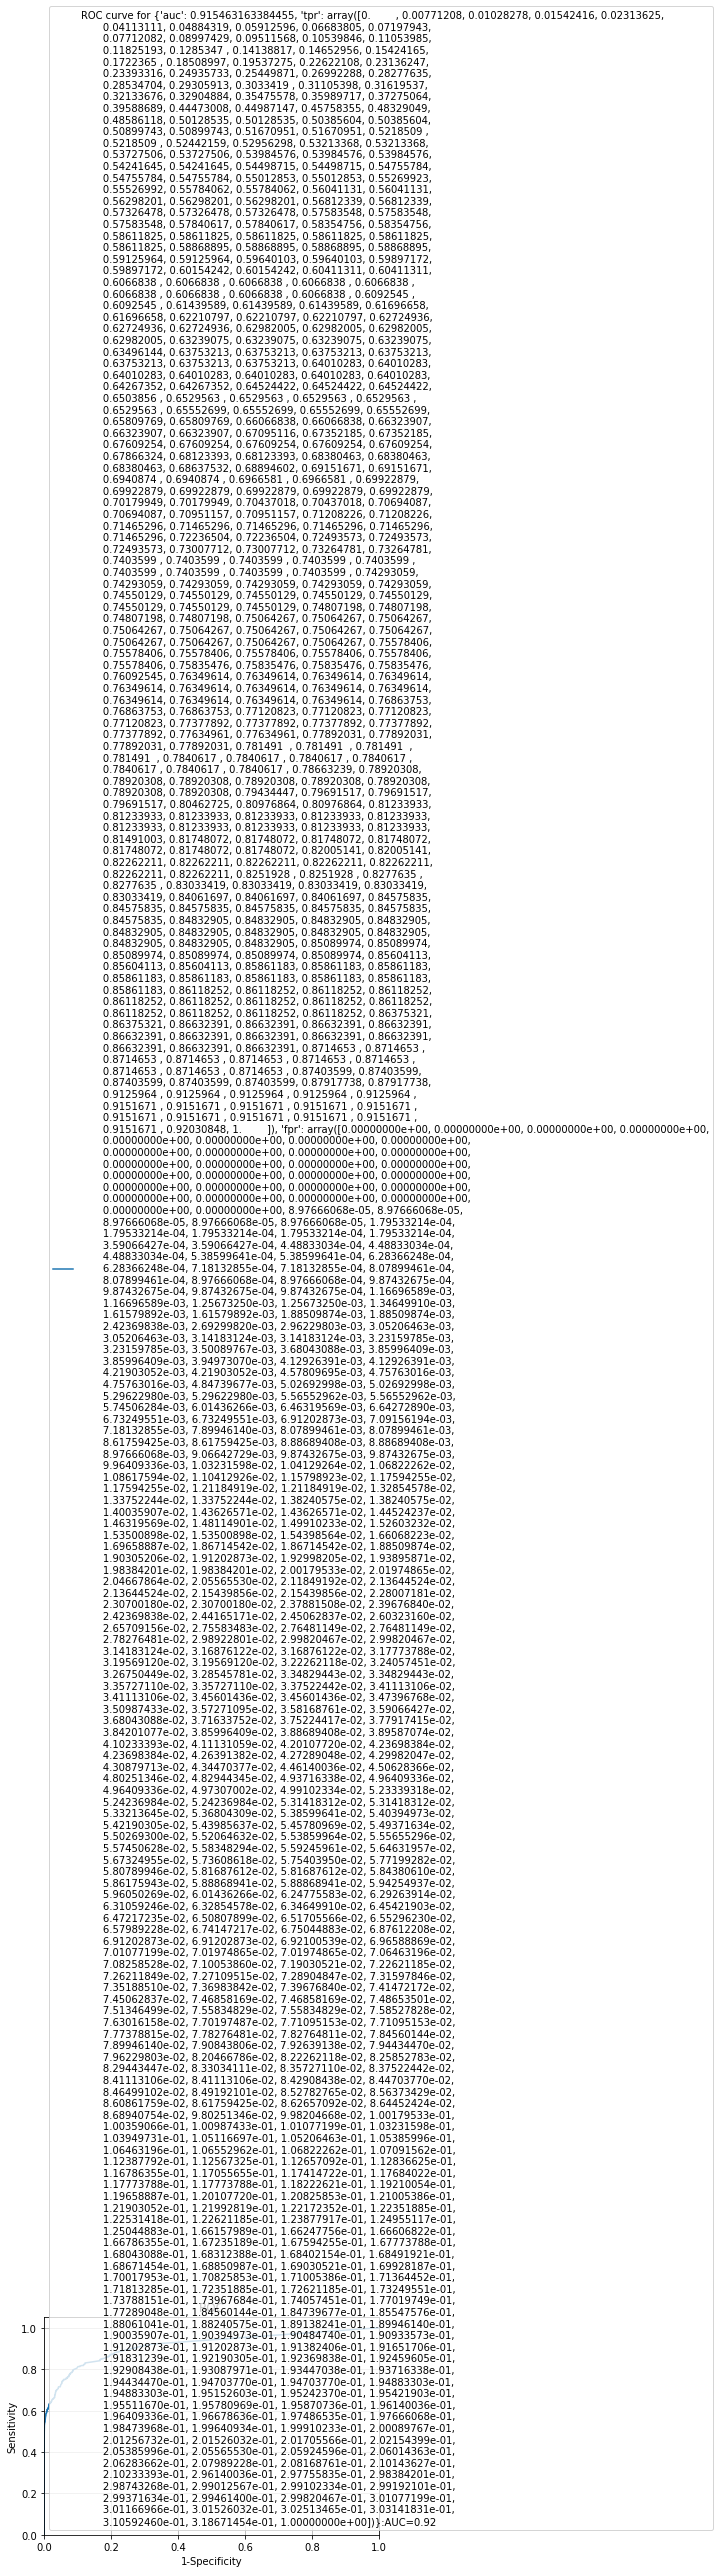

In [15]:
### AUROC ###
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(dataset.target), np.asarray(probs))
m = {"auc": metrics.roc_auc_score(np.asarray(dataset.target), np.asarray(probs)),
                    "tpr": tpr,
                    "fpr": fpr                        
                    }    

    
label = 'ROC curve for {0}:'.format(m)
plt.plot(m['fpr'], m['tpr'], label=label+'AUC={0:0.2f}'.format(m['auc']))
# plt.plot(m['fpr'], m['tpr'])

plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])


plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()

Text(28.5, 0.5, 'Predicted label')

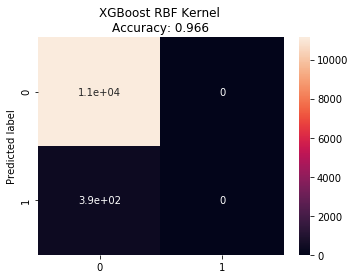

In [16]:
### MATRIZ DE CONFUSION ###

confusion_mc = confusion_matrix(train_labels,preds)
df_cm = pd.DataFrame(confusion_mc)

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('XGBoost RBF Kernel \nAccuracy: {0:.3f}'
        .format(accuracy_score(train_labels,preds)))
plt.ylabel('True label')
plt.ylabel('Predicted label')

In [17]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
dataset.columns

Index(['user_id', 'qty_adopciones_1M', 'qty_adopciones_3M',
       'qty_adopciones_6M', 'qty_adopciones_9M', 'mes', 'anio',
       'qty_dias_ultima_adopcion', 'qty_dias_ultimo_page_ingreso',
       'snapshot_mes_x',
       ...
       'ratio_adoption_preferencia_CONNECTION_SPEED_2.0',
       'ratio_adoption_preferencia_CONNECTION_SPEED_3.0',
       'ratio_adoption_interes_CONNECTION_SPEED', 'snapshot_mes',
       'ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_1',
       'ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_1.0',
       'ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_63.0',
       'ratio_adoption_preferencia_ON_SITE_SEARCH_TERM_89.0',
       'ratio_adoption_interes_ON_SITE_SEARCH_TERM', 'target'],
      dtype='object', length=30582)

In [19]:
pred_probs

array([[0.97678891, 0.02321109],
       [0.97678891, 0.02321109],
       [0.97678891, 0.02321109],
       ...,
       [0.97678891, 0.02321109],
       [0.97678891, 0.02321109],
       [0.97678891, 0.02321109]])

In [23]:
probs

[0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.03671295430943121,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.027497382579152033,
 0.027497382579152033,
 0.029862746367243575,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.07282782570000948,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.039059427033152516,
 0.02321108654504059,
 0.03749161813479687,
 0.02321108654504059,
 0.02321108654504059,
 0.027497382579152033,
 0.027497382579152033,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.06662921077778532,
 0.02321108654504059,
 0.02321108654504059,
 0.02321108654504059,
 0.07110126670458938,
 0.0

In [50]:
user_ids = list(dataset['user_id'])

In [51]:
user_ids = user_ids[:-1]

In [52]:
outcome = pd.DataFrame(user_ids, columns=['USER_ID'])

In [53]:
outcome.columns

Index(['USER_ID'], dtype='object')

In [54]:
outcome.tail(10)

,USER_ID
11519,11645
11520,11646
11521,11647
11522,11649
11523,11650
11524,11651
11525,11652
11526,11654
11527,11658
11528,11659


In [56]:
outcome['SCORE'] = probs
outcome.to_csv('submission.csv', index=False)

In [58]:
len(probs)

11529

In [59]:
len(user_ids)

11529